In [417]:

# import packages
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score 
import pickle
from skimage.feature import greycomatrix, greycoprops
from skimage.filters import hessian, median
import cv2

In [418]:
#get labels

labels = pd.read_csv('./dataset/label.csv')

#get images from file name
def fetch_image(row_id, root = "./dataset/image/"):
    file_name = f"IMAGE_{str.zfill(str(row_id), 4)}.jpg"
    file_path = os.path.join(root, file_name)
    img = Image.open(file_path)
    return np.array(img)

print(labels.label)

0       meningioma_tumor
1               no_tumor
2       meningioma_tumor
3           glioma_tumor
4       meningioma_tumor
              ...       
2995            no_tumor
2996    meningioma_tumor
2997        glioma_tumor
2998        glioma_tumor
2999     pituitary_tumor
Name: label, Length: 3000, dtype: object


In [ ]:

def glcm_features(image):
    contrast_arr = []
    dis_arr = []
    hom_arr = [] 
    asm_arr = []
    cor_arr =[]

    total_patches = np.lib.stride_tricks.sliding_window_view(image, (7,7))
    
    set_patches = total_patches[::50]
    
    for patches in set_patches:
        for patch in patches:
            # glcm features
            g = greycomatrix(patch, [5], [0, np.pi/2], levels=256)
            contrast_arr.append(greycoprops(g, 'contrast')[0,0]) 
            dis_arr.append(greycoprops(g, 'dissimilarity')[0,0])
            hom_arr.append(greycoprops(g, 'homogeneity')[0,0])
            asm_arr.append(greycoprops(g, 'ASM')[0,0])
            cor_arr.append(greycoprops(g, 'correlation')[0,0])

    return contrast_arr, dis_arr, hom_arr, asm_arr, cor_arr


In [419]:
def create_hog_features(img):
    # convert image to greyscale
    grey_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # remove black background
    grey_image = cv2.threshold(grey_image, 0, 255, cv2.THRESH_OTSU)
    
    # resize to standard scale
    grey_image = cv2.resize(rgb2gray(img), (256, 256), cv2.INTER_NEAREST)
    
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(8,8))
    
    # use median filter to denoise   
    grey_image = median(grey_image, mode = 'constant')
    
    # normalize to 0-255 range
    norm_image = cv2.normalize(grey_image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_image = norm_image.astype(np.uint8)
    
    # glcm features
    contrast, dis, hom, asm, cor = glcm_features(norm_image)
    
    features = np.hstack((hog_features, contrast, dis, hom, asm, cor))
    return features

print(create_hog_features(fetch_image(1)).shape)

(72910,)


In [420]:
def combine_features(labels):
    features = np.empty((0, create_hog_features(fetch_image(1)).shape[0]), int)
    
    for img_id in labels.index:
        # load image
        img = fetch_image(img_id)
        # get features for image
        image_features = create_hog_features(img)
        features = np.vstack([features,image_features])
        
    return features

feature_matrix = combine_features(labels)

In [421]:
ss = StandardScaler()

scaled_features = ss.fit_transform(feature_matrix)

# pca = PCA(n_components=200)

# pca_features = pca.fit_transform(scaled_features)


In [422]:
X = pd.DataFrame(scaled_features)
y = pd.Series(labels.label.values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123,
                                                    shuffle = True)

# look at the distrubution of labels in the train set
pd.Series(y_test).value_counts()

meningioma_tumor    264
pituitary_tumor     255
glioma_tumor        246
no_tumor            135
dtype: int64

In [423]:
param_grid={'C':[0.1,1],'gamma':[0.0001,0.001,0.1],'kernel':['rbf','poly']}
# define support vector classifier
svm = SVC(probability=True)

model = GridSearchCV(svm, param_grid)
# fit model
model.fit(X_train, y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1], 'gamma': [0.0001, 0.001, 0.1],
                         'kernel': ['rbf', 'poly']})

In [424]:
# generate predictions
y_pred = model.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.88


In [425]:
model.best_params_

{'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}

In [426]:
filename = './models/svm_model3.sav'
pickle.dump(model, open(filename, 'wb'))

Confusion matrix, without normalization
[[223  14   5   4]
 [ 27 220   1  16]
 [ 22  10  95   8]
 [  1   0   0 254]]
Normalized confusion matrix
[[0.90650407 0.05691057 0.0203252  0.01626016]
 [0.10227273 0.83333333 0.00378788 0.06060606]
 [0.16296296 0.07407407 0.7037037  0.05925926]
 [0.00392157 0.         0.         0.99607843]]


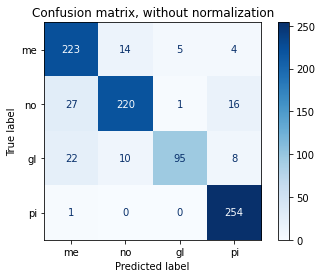

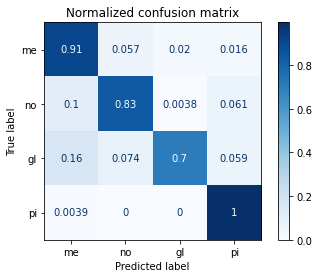

In [427]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=labels.label.str[:2].unique(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

In [428]:
print(classification_report(y_test, y_pred, target_names=labels.label.unique()))


                  precision    recall  f1-score   support

meningioma_tumor       0.82      0.91      0.86       246
        no_tumor       0.90      0.83      0.87       264
    glioma_tumor       0.94      0.70      0.81       135
 pituitary_tumor       0.90      1.00      0.95       255

        accuracy                           0.88       900
       macro avg       0.89      0.86      0.87       900
    weighted avg       0.88      0.88      0.88       900




cv = KFold(n_splits=10, shuffle=False)
r_scores = []

for train_idx, test_idx in cv.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
    model.fit(X_train, y_train)
    r_scores.append(optimised_model.score(X_test, y_test))
    

print(r_scores)

im = Image.fromarray(fetch_image(1, root = "./test/image"))
im.show()


In [429]:

test_labels = pd.read_csv('./test/label.csv')

def combine_test_features(test_labels):
    features = np.empty((0, create_hog_features(fetch_image(1, root = "./test/image")).shape[0]), int)
    
    for img_id in test_labels.index:
        # load image
        img = fetch_image(img_id, root = "./test/image/")
        # get features for image
        image_features = create_hog_features(img)
        features = np.vstack([features,image_features])
        
    return features

test_features = combine_test_features(test_labels)

In [430]:

ss = StandardScaler()

scaled_test_features = ss.fit_transform(test_features)

# pca = PCA(n_components=200)

# pca_test_features = pca.fit_transform(scaled_test_features)

testX = pd.DataFrame(scaled_test_features)
testY = pd.Series(test_labels.label.values)


testY_pred = model.predict(testX)
print(accuracy_score(testY, testY_pred))

0.82


Confusion matrix, without normalization
[[39  2  1  1]
 [ 9 53  0  6]
 [11  5 21  0]
 [ 1  0  0 51]]
Normalized confusion matrix
[[0.90697674 0.04651163 0.02325581 0.02325581]
 [0.13235294 0.77941176 0.         0.08823529]
 [0.2972973  0.13513514 0.56756757 0.        ]
 [0.01923077 0.         0.         0.98076923]]


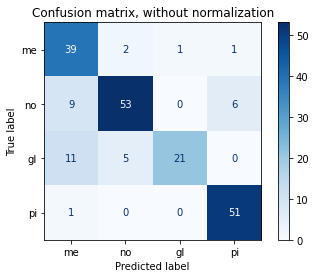

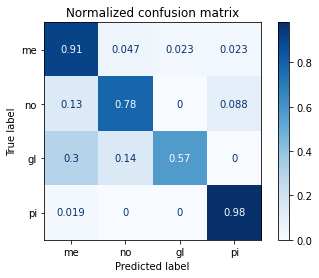

In [432]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        testX,
        testY,
        display_labels=labels.label.str[:2].unique(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

In [434]:
print(classification_report(testY, testY_pred, target_names=test_labels.label.unique()))

                  precision    recall  f1-score   support

meningioma_tumor       0.65      0.91      0.76        43
    glioma_tumor       0.88      0.78      0.83        68
 pituitary_tumor       0.95      0.57      0.71        37
        no_tumor       0.88      0.98      0.93        52

        accuracy                           0.82       200
       macro avg       0.84      0.81      0.81       200
    weighted avg       0.85      0.82      0.82       200

